### Dogs vs. Cats
Create an algorithm to distinguish dogs from cats

In [8]:
# Prepearing Necessary Libraries
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator,load_img
import random
import os

In [9]:
# check the version of tensor flow
print("TensorFlow Version:",tf.__version__)
print("Hub Verion :", hub.__version__)
print("GPU","Selected Yesss!!!" if tf.config.list_physical_devices("GPU") else "Not slected ")


TensorFlow Version: 2.2.0
Hub Verion : 0.8.0
GPU Selected Yesss!!!


### Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [10]:
#!unzip "/content/drive/My Drive/Dog Cat/train.zip" -d "/content/drive/My Drive/Dog Cat"

In [11]:

#!unzip "/content/drive/My Drive/Dog Cat/test1.zip" -d "/content/drive/My Drive/Dog Cat"

In [12]:
filenamd = os.listdir("/content/drive/My Drive/Dog Cat/train")
categories = []
for filename in filenamd:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenamd,
    'category': categories
})

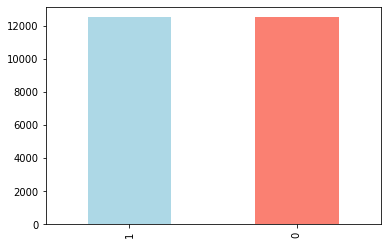

In [13]:
df['category'].value_counts().plot.bar(color=['lightblue','salmon']);

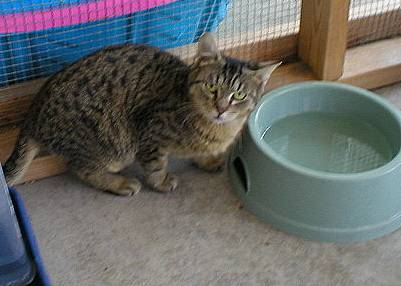

In [14]:
# Let's view an image
from IPython.display import Image
Image("drive/My Drive/Dog Cat/train/cat.2325.jpg")

In [15]:
## Getting images and their labels
#Let's get a list of all of our image file pathnames.
len(filenamd)

25000

In [16]:
filenamd[:10]

['cat.9573.jpg',
 'cat.9558.jpg',
 'cat.9598.jpg',
 'cat.9563.jpg',
 'cat.9551.jpg',
 'cat.9567.jpg',
 'cat.9595.jpg',
 'cat.9550.jpg',
 'cat.9539.jpg',
 'cat.9559.jpg']

In [17]:
df['category'] = df['category'].apply(lambda x: 'cat' if x==0 else 'dog')


In [18]:
df.head(5)

filename category
0  cat.9573.jpg      cat
1  cat.9558.jpg      cat
2  cat.9598.jpg      cat
3  cat.9563.jpg      cat
4  cat.9551.jpg      cat

In [19]:
df.category.value_counts()

dog    12500
cat    12500
Name: category, dtype: int64

Since we've now got our training image filepaths in a list, let's 

---

prepare our labels.

In [20]:
labels=df.category.to_numpy()
labels

array(['cat', 'cat', 'cat', ..., 'dog', 'dog', 'dog'], dtype=object)

In [21]:
len(labels)

25000

In [22]:
# Create pathnames from image ID's
filenames = ["drive/My Drive/Dog Cat/train/" + fname + ""  for fname in df["filename"]]

# Check the first 10
filenames[:10]

['drive/My Drive/Dog Cat/train/cat.9573.jpg',
 'drive/My Drive/Dog Cat/train/cat.9558.jpg',
 'drive/My Drive/Dog Cat/train/cat.9598.jpg',
 'drive/My Drive/Dog Cat/train/cat.9563.jpg',
 'drive/My Drive/Dog Cat/train/cat.9551.jpg',
 'drive/My Drive/Dog Cat/train/cat.9567.jpg',
 'drive/My Drive/Dog Cat/train/cat.9595.jpg',
 'drive/My Drive/Dog Cat/train/cat.9550.jpg',
 'drive/My Drive/Dog Cat/train/cat.9539.jpg',
 'drive/My Drive/Dog Cat/train/cat.9559.jpg']

In [23]:
# See if number of labels matches the number of filenames
if len(labels)==len(filenames):
  print("Labels and Filnames Matched !!! go ahead")
else :
    print("Labels and Filnames Not matched go back!!")

Labels and Filnames Matched !!! go ahead


In [24]:
unique_labels=np.unique(labels)
unique_labels

array(['cat', 'dog'], dtype=object)

In [25]:
print(labels[0])
labels[0]==unique_labels

cat


array([ True, False])

In [26]:
# See if number of labels matches the number of filenames
boolean_labels= [label == unique_labels for label in labels]
boolean_labels[:3]

[array([ True, False]), array([ True, False]), array([ True, False])]

In [27]:
len(boolean_labels)

25000

In [28]:
# Example: Turning boolean array into integers

print(labels[0]) # original label
print(np.where(unique_labels==labels[0])) # index where label occurs
print(boolean_labels[0].argmax())# index where label occur on boolean array
print(boolean_labels[0].astype(int))

cat
(array([0]),)
0
[1 0]


In [29]:
print(labels[2])
print(boolean_labels[2].astype(int))

cat
[1 0]


In [30]:
boolean_labels[:2]

[array([ True, False]), array([ True, False])]

### Creating our own validation set
Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [31]:
X=filenames
y=boolean_labels

# Let's split our data into train and validation sets

In [32]:
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid=train_test_split(X,y,
                                                 test_size=0.1,
                                                 random_state=42)

In [33]:
len(X_train),len(y_train),len(X_valid),len(y_valid)

(22500, 22500, 2500, 2500)

In [34]:
X_train[:3],y_train[:3]

(['drive/My Drive/Dog Cat/train/cat.6145.jpg',
  'drive/My Drive/Dog Cat/train/cat.10526.jpg',
  'drive/My Drive/Dog Cat/train/dog.6227.jpg'],
 [array([ True, False]), array([ True, False]), array([False,  True])])

### Preprocessing Images (turning images into Tensors)
To preprocess our images into Tensors we're going to write a function which does a few things:

1- Take an image filepath as input.

2- Use TensorFlow to read the file and save it to a variable, image.

3- Turn our image (a jpg) into Tensors.

3- Normalize our image (convert color channel values from from 0-255 to 0-1).

4- Resize the image to be a shape of (224, 224).

5- Return the modified image.

Before we do, let's see what importing an image looks like.


In [35]:
from matplotlib.pyplot import imread
image=imread(filenames[30])
image.shape

(374, 500, 3)

In [36]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/My Drive/Dog Cat/train/")) == len(filenames):
  print("Filenames match actual amount of files!!! Proceed.")
else:
  print("Filenames do no match actual amount of files, check the target director")

Filenames match actual amount of files!!! Proceed.


In [37]:
df['category'][5]

'cat'

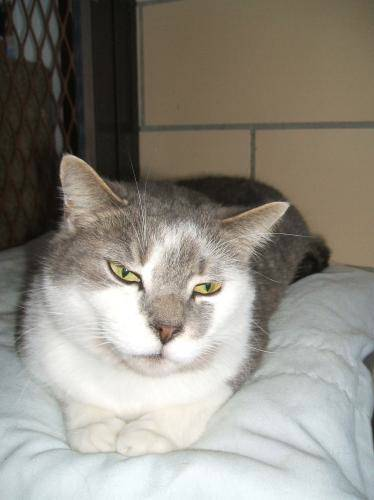

In [38]:
Image(filenames[90])

In [39]:
image.min(),image.max()

(0, 255)

In [40]:
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 500, 3), dtype=uint8, numpy=
array([[[73, 53, 26],
        [69, 49, 22],
        [65, 45, 18],
        ...,
        [67, 44, 28],
        [56, 33, 17],
        [57, 34, 18]],

       [[75, 55, 28],
        [72, 52, 25],
        [68, 48, 21],
        ...,
        [69, 46, 30],
        [60, 37, 21],
        [61, 38, 22]]], dtype=uint8)>

In [41]:
# Define image size
IMG_Size=224

In [42]:
# Create a function for preprocessing images
def process_image(file_name,image_size=IMG_Size):
  # Load the image
  image=tf.io.read_file(file_name)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image=tf.image.decode_jpeg(image,channels=3)
  # Convert the color channel
  image=tf.image.convert_image_dtype(image,tf.float32)
  # Resize the image
  image=tf.image.resize(image,size=[image_size,image_size])

  return image




## Turning our data into batches


In [43]:
# Create a simple function to return a tuple (image, label)

def get_image_label(img_path,label):
  image=process_image(img_path)
  return image,label

In [44]:
# Demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.15200455, 0.27749476, 0.32236272],
         [0.14555697, 0.2506515 , 0.3254777 ],
         [0.09733149, 0.1690677 , 0.29478547],
         ...,
         [0.23545067, 0.3452546 , 0.2520298 ],
         [0.14928104, 0.25904626, 0.20903593],
         [0.08227105, 0.17862965, 0.21058966]],
 
        [[0.18005455, 0.31444705, 0.3454982 ],
         [0.06977416, 0.18891808, 0.23283315],
         [0.2007791 , 0.28787392, 0.37047198],
         ...,
         [0.1414276 , 0.2513816 , 0.20200808],
         [0.07055226, 0.16322815, 0.17129101],
         [0.04555653, 0.11695014, 0.20111476]],
 
        [[0.13829407, 0.27919918, 0.3281575 ],
         [0.16775335, 0.29579458, 0.33854792],
         [0.06366175, 0.17512885, 0.2214724 ],
         ...,
         [0.04556057, 0.15845451, 0.18749852],
         [0.01675432, 0.09976274, 0.1841524 ],
         [0.042387  , 0.09315242, 0.24059366]],
 
        ...,
 
        [[0.19631918, 0.25906426

Now we've got a way to turn our data into tuples of Tensors in the form: (image, label), let's make a function to turn all of our data (X & y) into batches!

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if need be).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: 
`(image, label)`.

In [45]:
BATCH_SIZE=32

In [46]:
# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch
 

In [47]:
# Create training and validation data batche
train_data=create_data_batches(X_train,y_train)
val_data=create_data_batches(X_valid,y_valid,valid_data=True )

Creating training data batches...
Creating validation data batches...


In [48]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 2), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 2), dtype=tf.bool, name=None)))

## Visualizing Data Batches
Our data is now in batches, however, these can be a little hard to understand/comprehend, let's visualize them!

```
# This is formatted as code
```



In [51]:
# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image 
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_labels[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [52]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 2)), types: (tf.float32, tf.bool)>

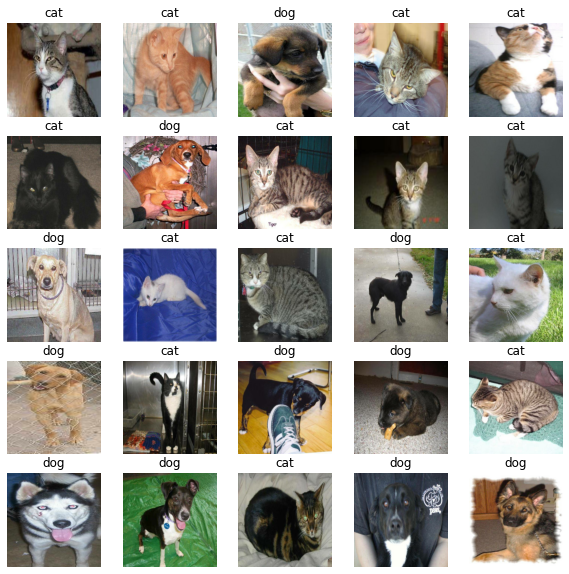

In [53]:
# # Now let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator()) # turn into numpy
show_25_images(train_images, train_labels)

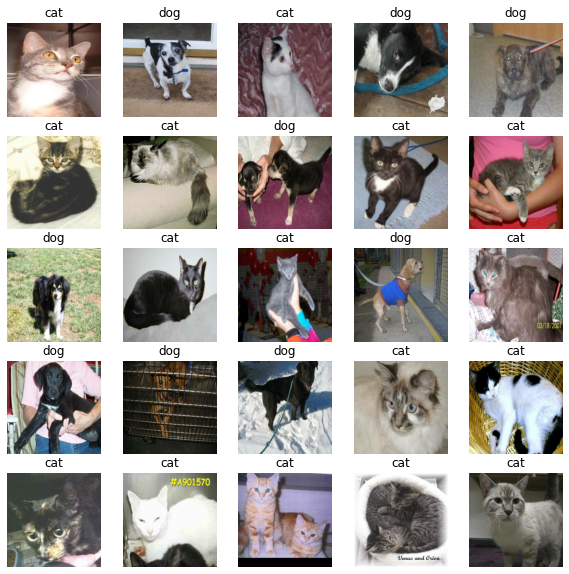

In [54]:
# # Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

In [55]:
# Setup input shape to the model
INPUT_SHAPE = [None, 224, 224, 3] # batch, height, width, colour channels

# Setup output shape of our model / CAT or DOG
OUTPUT_SHAPE = len(unique_labels)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [56]:
OUTPUT_SHAPE

2

### Learning Model
Now we've got our inputs, outputs and model ready to go. Let's put them together into a Keras deep learning model!

In [57]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [58]:
model=create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  2004      
Total params: 5,434,717
Trainable params: 2,004
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

In [59]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [60]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Dog Cat/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.


In [61]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

### Training a model (on subset of data)

Our first model is only going to train all images, to make sure everything is working.

In [62]:
NUM_EPOCHS=100 #@param {type:'slider',min:10,max:100,steps:10}

In [63]:
# Check to make sure we're still running on a GPU
print("GPU","Available GPU Yesssss!!!" if tf.config.list_physical_devices("GPU") else "Not Avalialbe ")

GPU Available GPU Yesssss!!!


Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use
* Return the model

In [64]:
# Build a function to train and return a trained model
from keras.preprocessing.image import ImageDataGenerator

def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model

  model=create_model()
  # Create new TensorBoard session everytime we train a model
  tensorboard=create_tensorboard_callback()
  # Fit the model to the data passing it the callbacks we created
  # data augmentation


  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard,early_stopping])
  # Return the fitted model

  return model





In [1]:
  # Fit the model to the data
  model=train_model()

NameError: ignored

In [ ]:
%tensorboard --logdir drive/My\ Drive/Dog\ Cat/logs

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 2)), types: (tf.float32, tf.bool)>

In [ ]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

79/79 [==============================] - 12s 154ms/step


array([[9.9997830e-01, 2.1747159e-05],
       [1.2757547e-05, 9.9998724e-01],
       [9.9999928e-01, 6.5827169e-07],
       ...,
       [7.6931738e-06, 9.9999225e-01],
       [1.4281155e-04, 9.9985719e-01],
       [9.9999988e-01, 1.4438119e-07]], dtype=float32)

In [ ]:
# First prediction
index = 42
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_labels[np.argmax(predictions[index])]}")

[1.4004379e-05 9.9998605e-01]
Max value (probability of prediction): 0.9999860525131226
Sum: 1.0
Max index: 1
Predicted label: dog


In [ ]:
unique_labels[1]

'dog'

*Having* the the above functionality is great but we want to be able to do it at scale.

And it would be even better if we could see the image the prediction is being made on!

**Note:** Prediction probabilities are also known as confidence levels.

In [ ]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_labels[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

NameError: ignored

Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels).




In [ ]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and reutrns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_labels[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

NameError: ignored

Now we've got ways to get get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some function to make these all a bit more visaulize.

We'll create a function which:
* Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer. ✅
* Convert the prediction probabilities to a predicted label. ✅
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot. ✅

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  
  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

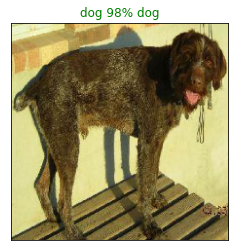

In [ ]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=90)

Now we've got one function to visualize our models top prediction, let's make another to view our models top 10 predictions.

This function will:
* Take an input of prediction probabilities array and a ground truth array and an integer ✅
* Find the prediction using `get_pred_label()` ✅
* Find the top 10:
  * Prediction probabilities indexes ✅
  * Prediction probabilities values ✅
  * Prediction labels ✅
* Plot the top 10 prediction probability values and labels, coloring the true label green ✅

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_labels[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

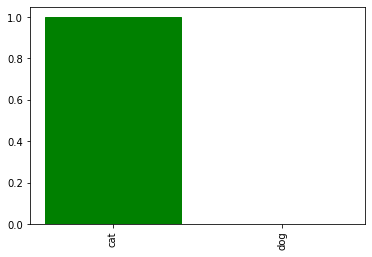

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=500)

Now we've got some function to help us visualize our predictions and evaluate our modle, let's check out a few.

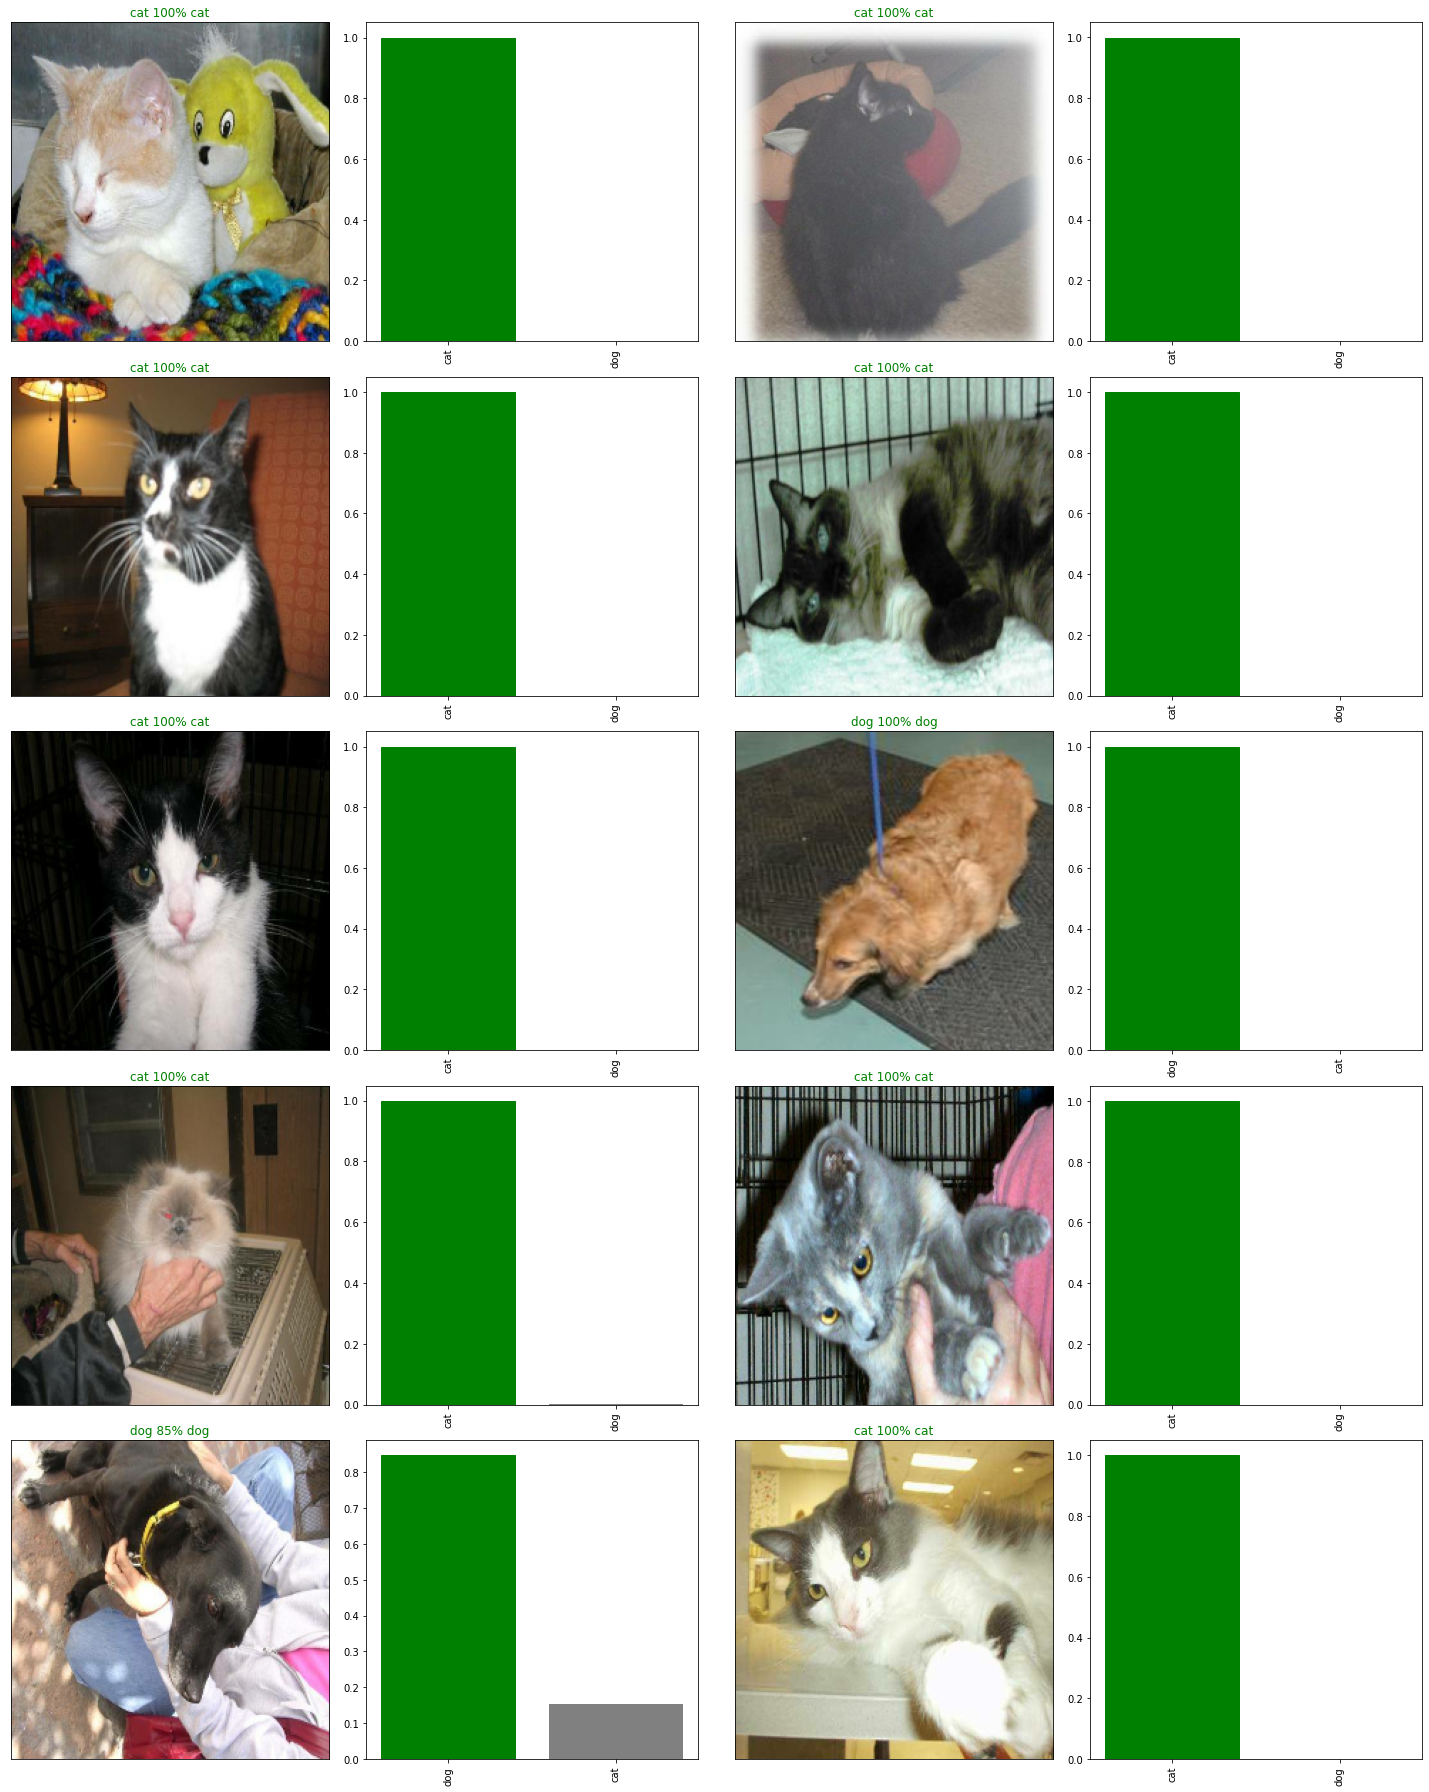

In [ ]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 5
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

### Confusion matrix

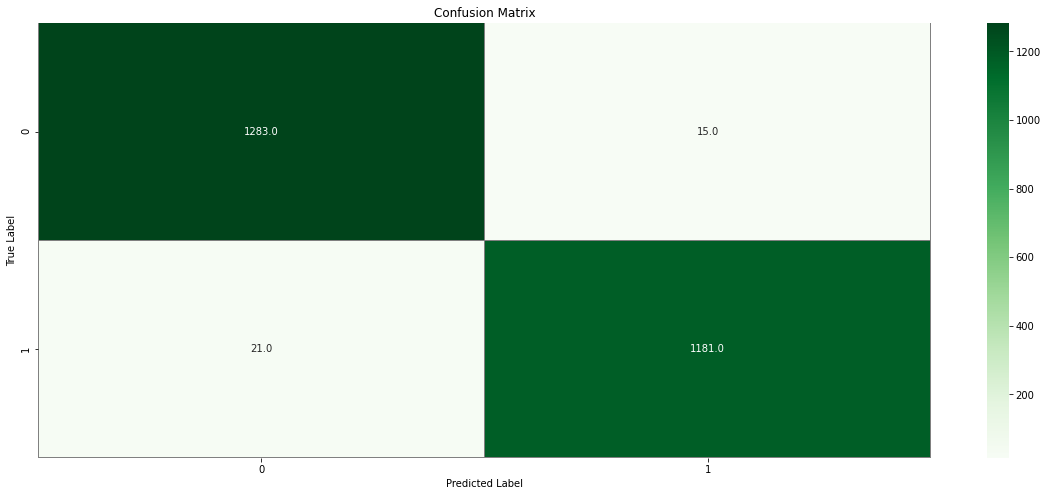

In [ ]:
# confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas.util.testing as tm

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(predictions,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_valid,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(20, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix");


In [ ]:
# evaluate the model
train_acc = model.evaluate(train_data, verbose=0)
test_acc = model.evaluate(val_data, verbose=0)
train_acc,test_acc

([0.020837686955928802, 0.9929777979850769],
 [0.044688910245895386, 0.9855999946594238])

## Saving and reloading a trained model


In [ ]:
# Create function to save the model
def save_model(model,suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
    # Create a model directory pathname with current time
  modeldir=os.path.join("drive/My Drive/Dog Cat/models",
                       datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  
  return model_path 


In [ ]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path, 
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

Now we've got functions to save and load a trained model, let's make sure they work!

In [ ]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: drive/My Drive/Dog Cat/models/20200725-09241595669061-1000-images-mobilenetv2-Adam.h5...


'drive/My Drive/Dog Cat/models/20200725-09241595669061-1000-images-mobilenetv2-Adam.h5'

In [ ]:
saved_model=load_model("drive/My Drive/Dog Cat/models/20200725-09241595669061-1000-images-mobilenetv2-Adam.h5")

Loading saved model from: drive/My Drive/Dog Cat/models/20200725-09241595669061-1000-images-mobilenetv2-Adam.h5


## Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take a list of filenames as input and conver them into Tensor batches.

To make predictions on the test data, we'll:
* Get the test image filenames. ✅
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since the test data doesn't have labels). ✅
* Make a predictions array by passing the test batches to the `predict()` method called on our model. 

In [ ]:
# Load test image filenames
test_path = "drive/My Drive/Dog Cat/test1/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/My Drive/Dog Cat/test1/1.jpg',
 'drive/My Drive/Dog Cat/test1/10.jpg',
 'drive/My Drive/Dog Cat/test1/100.jpg',
 'drive/My Drive/Dog Cat/test1/1000.jpg',
 'drive/My Drive/Dog Cat/test1/10000.jpg',
 'drive/My Drive/Dog Cat/test1/10001.jpg',
 'drive/My Drive/Dog Cat/test1/10002.jpg',
 'drive/My Drive/Dog Cat/test1/10003.jpg',
 'drive/My Drive/Dog Cat/test1/10004.jpg',
 'drive/My Drive/Dog Cat/test1/10005.jpg']

In [ ]:

len(test_filenames)

12500

In [ ]:
Image('drive/My Drive/Dog Cat/test1/10005.jpg')

NameError: ignored

In [ ]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [ ]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

**Note:** Calling `predict()` on our  model and passing it the test data batch  and get our model to find patterns in those images and generate predictions based on what its learned in the training dataset.

In [ ]:
# Make predictions on test data batch using the loaded full model
test_predictions = saved_model.predict(test_data,
                                             verbose=1)

391/391 [==============================] - 57s 145ms/step


In [ ]:
# Save predictions (NumPy array) to csv file (for access later)
##np.savetxt("drive/My Drive/Dog Cat/preds_array.csv", test_predictions, delimiter=",")

In [ ]:
test_predictions.shape

(12500, 2)

## Making predictions on custom images

To make predictions on custom images, we'll:
* Get the filepaths of our own images.
* Turn the filepaths into data batches using `create_data_batches()`. And since our custom images won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict()` method.
* Convert the prediction output probabilities to predictions labels.
* Compare the predicted labels to the custom images.

In [ ]:
# Get custom image filepaths
custom_path = "drive/My Drive/Dog Cat/test1/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [ ]:
custom_image_paths[:10]

['drive/My Drive/Dog Cat/test1/1.jpg',
 'drive/My Drive/Dog Cat/test1/10.jpg',
 'drive/My Drive/Dog Cat/test1/100.jpg',
 'drive/My Drive/Dog Cat/test1/1000.jpg',
 'drive/My Drive/Dog Cat/test1/10000.jpg',
 'drive/My Drive/Dog Cat/test1/10001.jpg',
 'drive/My Drive/Dog Cat/test1/10002.jpg',
 'drive/My Drive/Dog Cat/test1/10003.jpg',
 'drive/My Drive/Dog Cat/test1/10004.jpg',
 'drive/My Drive/Dog Cat/test1/10005.jpg']

In [ ]:
# Turn custom images into batch datasets 
custom_data = create_data_batches(custom_image_paths[:10], test_data=True)
custom_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [ ]:
# Make predictions on the custom data
custom_preds = saved_model.predict(custom_data)

In [ ]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat']

In [ ]:
# Get custom images (our unbatchify() function won't work since there aren't labels... maybe we could fix this later)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

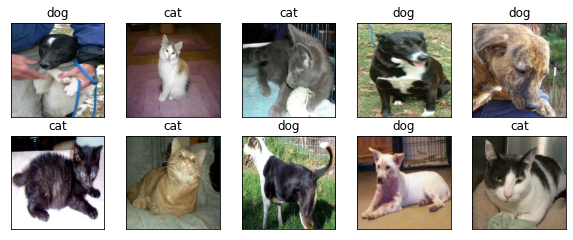

In [ ]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)